In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import random
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import os
from tqdm import tqdm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 3090
GPU memory: 24252.69 MB


In [9]:
class DeepONet_g(nn.Module):
    def __init__(self, g_dim, hidden_dim):
        super().__init__()
        # Branch Net dim_input = 1 + f_dim + g_dim
        self.g_dim = g_dim
        self.branch_net = nn.Sequential(
            nn.Linear(1 + g_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.trunk_net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, k, g, x):
        """
        k: (B, 1)
        g: (B, g_dim)
        x: (M, 2)   
        """
        branch_input = torch.cat([k, g], dim=1)  # shape (B, 1+f_dim+g_dim)
        branch_out = self.branch_net(branch_input)  # shape (B, H)
        trunk_out = self.trunk_net(x)               # shape (M, 2)

        return torch.einsum('bi,mi->bm', branch_out, trunk_out)

In [10]:
class DeepONet_f(nn.Module):
    def __init__(self, f_dim, hidden_dim):
        super().__init__()
        # Branch Net dim_input = 1 + f_dim + g_dim
        self.f_dim = f_dim
        self.branch_net = nn.Sequential(
            nn.Linear(1 + f_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.trunk_net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, k, f, x):
        """
        k: (B, 1)
        f: (B, f_dim)
        x: (M, 2)   
        """
        branch_input = torch.cat([k, f], dim=1)  # shape (B, 1+f_dim+g_dim)
        branch_out = self.branch_net(branch_input)  # shape (B, H)
        trunk_out = self.trunk_net(x)               # shape (M, 2)

        return torch.einsum('bi,mi->bm', branch_out, trunk_out)

In [11]:
NN = 40
M = (NN + 1) * (NN + 1)

In [12]:
net_g = DeepONet_g(g_dim = 4 * NN, hidden_dim = M // 4).to(device)
net_g.load_state_dict(torch.load("./DeepONet_g/net.pth", map_location=device))
net_g.eval()  

/tmp/ipykernel_3197/3857096930.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_g.load_state_dict(torch.load("./DeepONet_g/net.pth", map_location=device))


DeepONet_g(
  (branch_net): Sequential(
    (0): Linear(in_features=161, out_features=420, bias=True)
    (1): ReLU()
    (2): Linear(in_features=420, out_features=420, bias=True)
    (3): ReLU()
    (4): Linear(in_features=420, out_features=420, bias=True)
    (5): ReLU()
    (6): Linear(in_features=420, out_features=420, bias=True)
    (7): ReLU()
    (8): Linear(in_features=420, out_features=420, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=2, out_features=420, bias=True)
    (1): ReLU()
    (2): Linear(in_features=420, out_features=420, bias=True)
    (3): ReLU()
    (4): Linear(in_features=420, out_features=420, bias=True)
    (5): ReLU()
    (6): Linear(in_features=420, out_features=420, bias=True)
    (7): ReLU()
    (8): Linear(in_features=420, out_features=420, bias=True)
  )
)

In [13]:
net_f = DeepONet_f(f_dim = M, hidden_dim = M // 4).to(device)
net_f.load_state_dict(torch.load("./DeepONet_f/net.pth", map_location=device))
net_f.eval()  

/tmp/ipykernel_3197/4196852335.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_f.load_state_dict(torch.load("./DeepONet_f/net.pth", map_location=device))


DeepONet_f(
  (branch_net): Sequential(
    (0): Linear(in_features=1682, out_features=420, bias=True)
    (1): ReLU()
    (2): Linear(in_features=420, out_features=420, bias=True)
    (3): ReLU()
    (4): Linear(in_features=420, out_features=420, bias=True)
    (5): ReLU()
    (6): Linear(in_features=420, out_features=420, bias=True)
    (7): ReLU()
    (8): Linear(in_features=420, out_features=420, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=2, out_features=420, bias=True)
    (1): ReLU()
    (2): Linear(in_features=420, out_features=420, bias=True)
    (3): ReLU()
    (4): Linear(in_features=420, out_features=420, bias=True)
    (5): ReLU()
    (6): Linear(in_features=420, out_features=420, bias=True)
    (7): ReLU()
    (8): Linear(in_features=420, out_features=420, bias=True)
  )
)

In [14]:
def U(x):
    x1 = x[:, 0].view(-1, 1)
    x2 = x[:, 1].view(-1, 1)
    return torch.exp(0.6 * x1 + 0.8 * x2) + torch.sin(x1) * torch.cos(x2)

def F(x, tau):
    x1 = x[:, 0].view(-1, 1)
    x2 = x[:, 1].view(-1, 1)
    u = torch.exp(0.6 * x1 + 0.8 * x2) + torch.sin(x1) * torch.cos(x2)
    laplace = torch.exp(0.6 * x1 + 0.8 * x2) - 2 * torch.sin(x1) * torch.cos(x2)
    return u - tau * laplace

def computeErrors(u_exact, u_pre, printOrNot):
    if isinstance(u_exact, np.ndarray):
        u_exact = torch.from_numpy(u_exact)
    if isinstance(u_pre, np.ndarray):
        u_pre = torch.from_numpy(u_pre)
    
    error = u_exact - u_pre
    l2_norm_abs = torch.norm(error, p=2).item() / torch.sqrt(torch.tensor(error.numel(), dtype=torch.float))
    max_norm_abs = torch.norm(error, p=float('inf')).item()
    l2_norm_rel = torch.norm(error, p=2).item() / torch.norm(u_exact, p=2).item()
    max_norm_rel = torch.norm(error, p=float('inf')).item() / torch.norm(u_exact, p=float('inf')).item()  
    
    l2_norm_rel_percent = l2_norm_rel * 100
    max_norm_rel_percent = max_norm_rel * 100
    
    if printOrNot == True:
        print(f"Absolute L2 Norm Error: {l2_norm_abs:.6f}")
        print(f"Absolute Max Norm Error: {max_norm_abs:.6f}")
        print(f"Relative L2 Norm Error: {l2_norm_rel_percent:.4f}%")
        print(f"Relative Max Norm Error: {max_norm_rel_percent:.4f}%")

    return l2_norm_rel


def plotSolutions(u_exact, u_pre, N):
    if isinstance(u_exact, torch.Tensor):
        u_exact = u_exact.cpu().detach().numpy()
    if isinstance(u_pre, torch.Tensor):
        u_pre = u_pre.cpu().detach().numpy()

    u_exact = u_exact.reshape((N, N))
    u_pre = u_pre.reshape((N, N))
    error = u_exact - u_pre
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    cax1 = axs[0].imshow(u_pre, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[0].set_title('Predicted Solution')
    fig.colorbar(cax1, ax=axs[0])

    cax2 = axs[1].imshow(u_exact, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[1].set_title('Exact Solution')
    fig.colorbar(cax2, ax=axs[1])

    cax3 = axs[2].imshow(np.abs(error), cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[2].set_title('Error')
    fig.colorbar(cax3, ax=axs[2])

    plt.show()

In [15]:
def evaluate_DeepOnet_Model(model_g, model_f, tau):

    # ========== Step 1: prepare test data ==========

    # Build test grid
    x_vals = np.linspace(0, 1, 41)
    X, Y = np.meshgrid(x_vals, x_vals)
    x_grid = np.stack([X.flatten(), Y.flatten()], axis=1)  # (1681, 2)
    x_tensor = torch.tensor(x_grid, dtype=torch.float32).to(device)

    # Compute f(x), u(x)
    with torch.no_grad():
        f_tensor = F(x_tensor, tau).reshape(1, -1)
        u_exact_tensor = U(x_tensor).reshape(1, -1)       # (1, 1681)

    # Build g from f (only use boundary entries)
    u_np_2d = u_exact_tensor.cpu().numpy().reshape(41, 41)
    g_boundary = np.concatenate([
        u_np_2d[0, :],            
        u_np_2d[1:, 40],          
        u_np_2d[40, 39::-1],        
        u_np_2d[39:0:-1, 0],       
    ])

    g_tensor = torch.tensor(g_boundary.reshape(1, -1), dtype=torch.float32).to(device)  # (1, 160)

    # k
    k_tensor = torch.tensor([[tau]], dtype=torch.float32).to(device)

    # ========== Step 2: model prediction ==========
    model_g.eval()
    with torch.no_grad():
        u_pred_tensor_g = model_g(k_tensor, g_tensor, x_tensor)  # (1, 1681)

    model_f.eval()
    with torch.no_grad():
        u_pred_tensor_f = model_f(k_tensor, f_tensor, x_tensor)  # (1, 1681)

    # ========== Step 3: error and visualization ==========
    u_exact = u_exact_tensor.view(-1)
    u_pred = (u_pred_tensor_g + u_pred_tensor_f).view(-1)

    plotSolutions(u_exact, u_pred, N=41)
    computeErrors(u_exact, u_pred, 1)

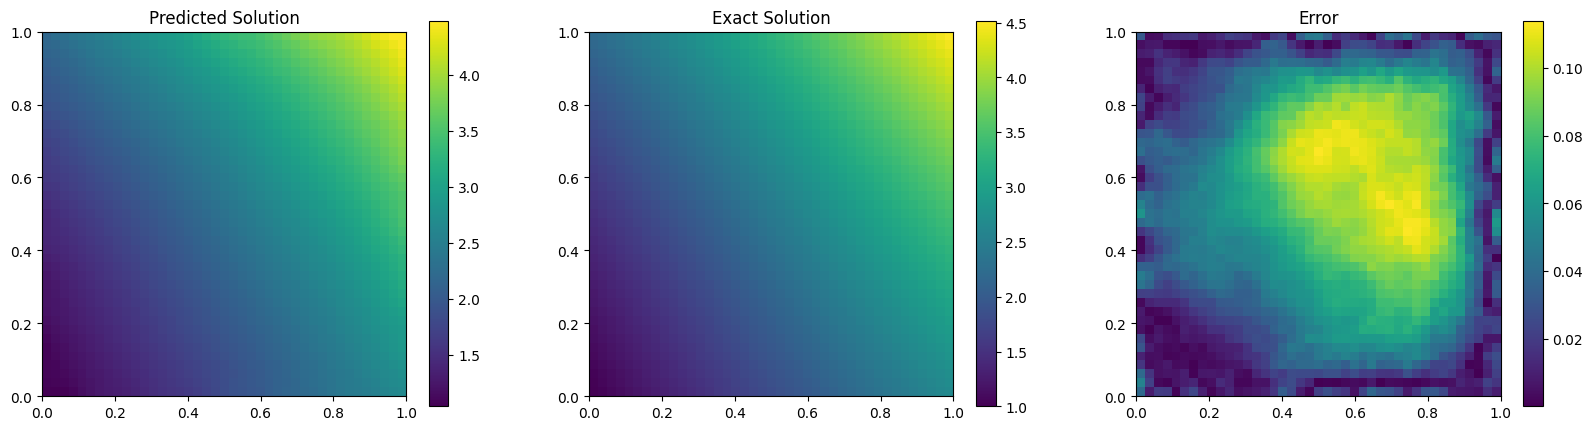

Absolute L2 Norm Error: 0.061395
Absolute Max Norm Error: 0.113780
Relative L2 Norm Error: 2.3681%
Relative Max Norm Error: 2.5229%


In [16]:
evaluate_DeepOnet_Model(net_g, net_f, 0.05)

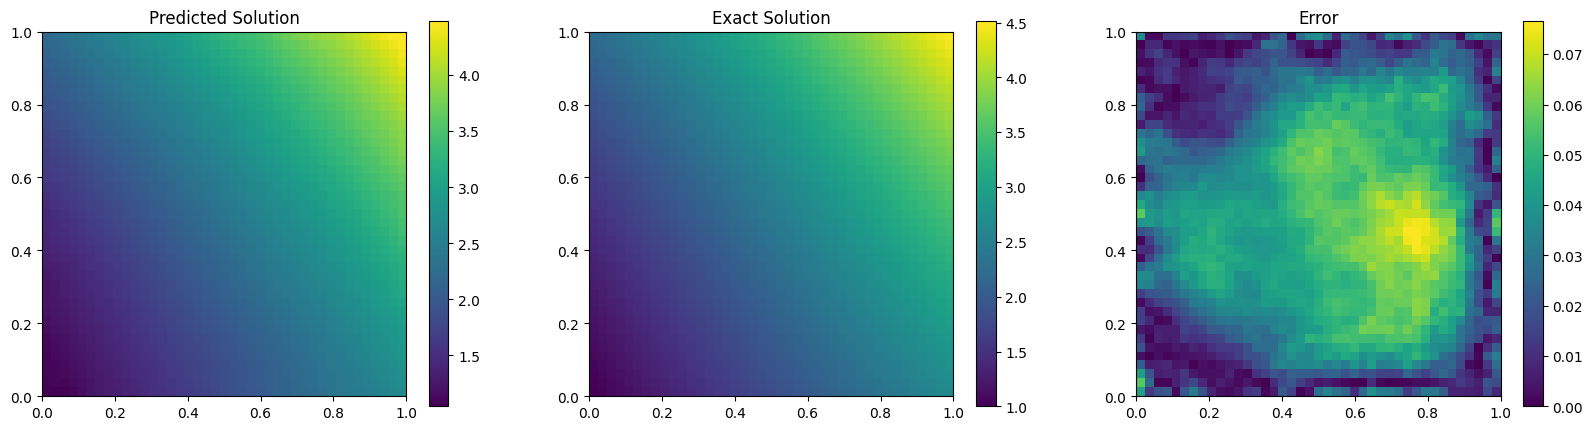

Absolute L2 Norm Error: 0.039092
Absolute Max Norm Error: 0.076514
Relative L2 Norm Error: 1.5078%
Relative Max Norm Error: 1.6966%


In [17]:
evaluate_DeepOnet_Model(net_g, net_f, 0.06)

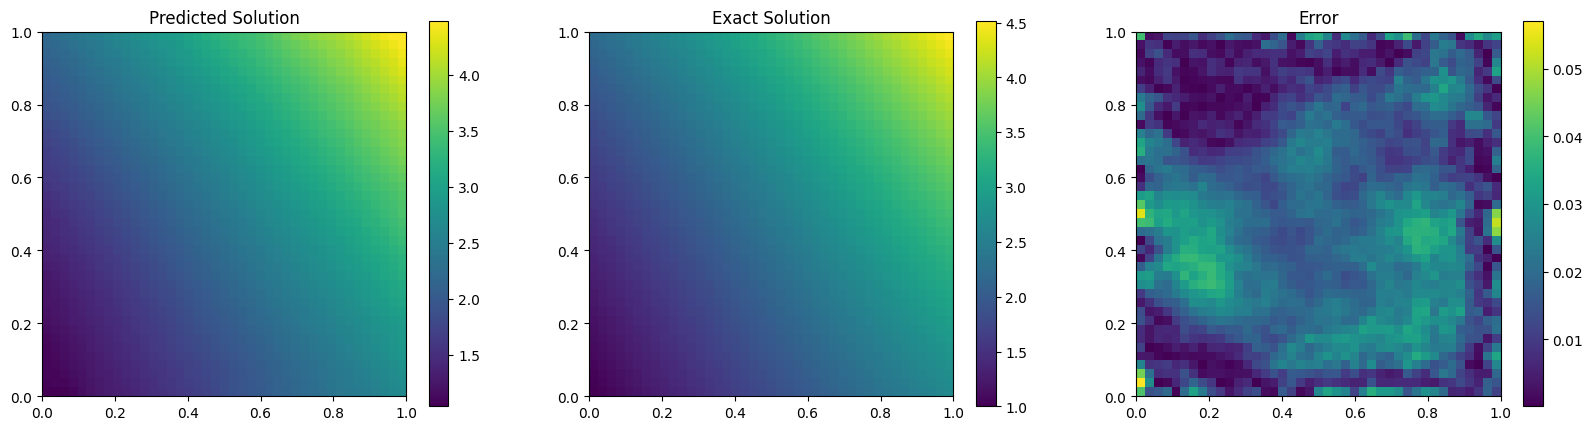

Absolute L2 Norm Error: 0.019360
Absolute Max Norm Error: 0.057026
Relative L2 Norm Error: 0.7468%
Relative Max Norm Error: 1.2645%


In [18]:
evaluate_DeepOnet_Model(net_g, net_f, 0.07)

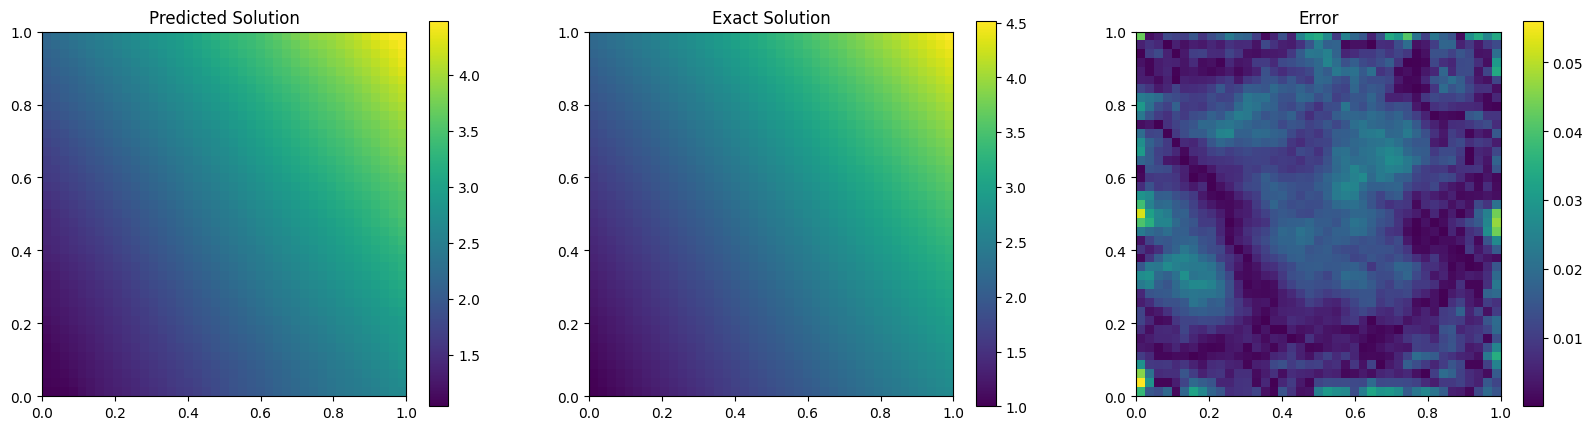

Absolute L2 Norm Error: 0.013424
Absolute Max Norm Error: 0.055964
Relative L2 Norm Error: 0.5178%
Relative Max Norm Error: 1.2409%


In [19]:
evaluate_DeepOnet_Model(net_g, net_f, 0.08)

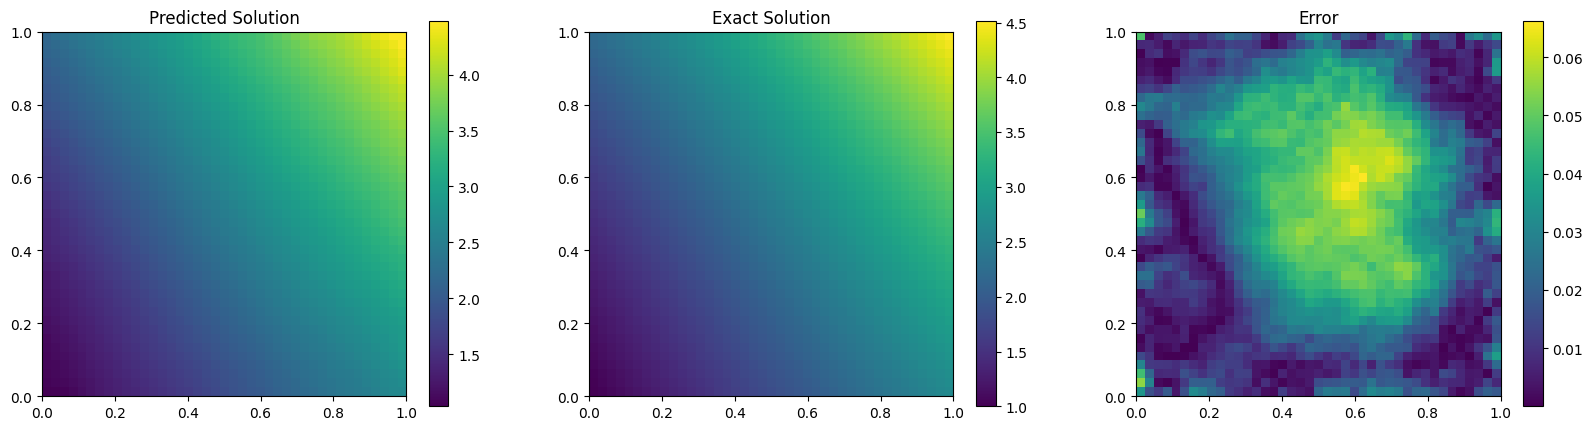

Absolute L2 Norm Error: 0.031047
Absolute Max Norm Error: 0.066160
Relative L2 Norm Error: 1.1975%
Relative Max Norm Error: 1.4670%


In [20]:
evaluate_DeepOnet_Model(net_g, net_f, 0.09)

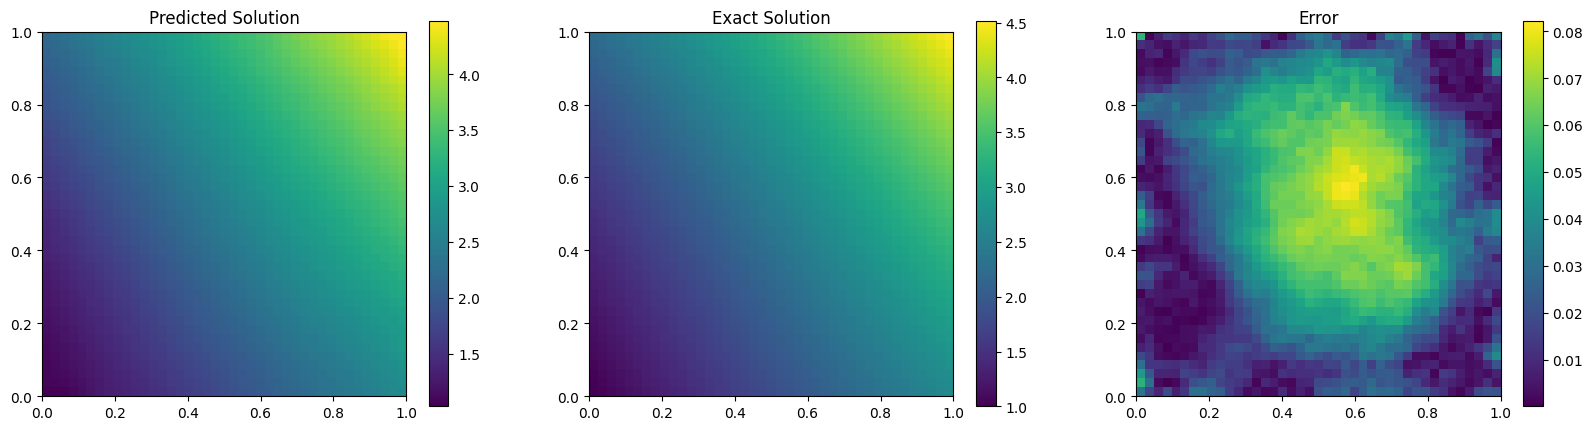

Absolute L2 Norm Error: 0.039467
Absolute Max Norm Error: 0.082124
Relative L2 Norm Error: 1.5223%
Relative Max Norm Error: 1.8210%


In [21]:
evaluate_DeepOnet_Model(net_g, net_f, 0.1)